Update February 21st 2019 - ANALYSIS
--
We performed all classification experiments again the evoked response filtering in low frequency (low pass 30 Hz), and  we selected components using a Kbest with 40 electrodes, before training the classifiers. 

We train classifiers on one condition, and test it on the same or other condition (eg. Train Regular, Test Regular), so this is why we get four graphs. 

One interesting part would be to observe a group difference in the respect to which classifiers in one group are able to generalize across conditions, or not. 

For instance, one interesting hypothesis to test would be : 

- Classifiers trained on controls do generalize from the pattern trained in Regular when tested in Irregular, or the opposite. 
- Classifiers trained on Patients data are less/not able to generalize across conditions.


In [1]:
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline 
import os 
from statsmodels.stats import multitest

statspath = '/home/nfarrugi/datasets/mpi_pd_cueing/results_fkbest40_filter/'

Step 0 - preparing data 

fields for the saved stats files are : 
- scores
- proba
- pval
- U

For each of them, layout is 4 (Regreg,RegIrreg,IrregReg,IrregIrreg) x CV x TestTime x TrainTime

Group files per subject type (patients or control) 

In [2]:
allsubj = os.listdir(statspath)

controls_id = []
patients_id = []

for cursubj in allsubj:
    if (cursubj[9]=='k'):
        controls_id.append(cursubj)
    else:
        if cursubj[10]=='1':
            patients_id.append(cursubj)
            

In [3]:
len(patients_id)

20

In [4]:
len(controls_id)

20

In [5]:
def diagonal_group(subjlist,statspath,thresh_unc = 0.01,timevec=None,showall=False,threshold_zeros=40,doplots=True,keepall=True,onlyregreg=False):


    if (showall):
        print("Showing all subjects")
    else:
        print("Showing subjects with less than %d FDR significant points" % threshold_zeros)
    
    diag_sig_fdr_all = []
    diag_sig_unc_all = []
    diag_ROC_all = []
    for subj in subjlist:
        cursubj = os.path.join(statspath,subj)
        curroc = np.load(cursubj)['scores'].mean(axis=1)
        curpvals = np.load(cursubj)['pval'].mean(axis=1) # Calculating mean p-value accross CV splits 
        diag_pvals = np.stack([np.diag(curmat) for curmat in curpvals]) # extract diagonal classification for each condition pair

        diag_ROC = np.stack([np.diag(curmat) for curmat in curroc]) # extract diagonal classification
        
        diag_sig_fdr = []
        diag_sig_unc = []
        
        if onlyregreg:
            H,p,_,_=multitest.multipletests(diag_pvals[2],method='fdr_bh')
            H_unc = diag_pvals[2] < thresh_unc
            diag_sig_unc.append(H_unc)
            diag_sig_fdr.append(H)        
        else:
            for curdiag in diag_pvals:
                H,p,_,_=multitest.multipletests(curdiag,method='fdr_bh')
                H_unc = curdiag < thresh_unc
                diag_sig_unc.append(H_unc)
                diag_sig_fdr.append(H)

        
        nonzeros = np.sum(np.stack(diag_sig_fdr))
        if showall:
            print("Subj %s number of non-zeros FDR : %d " %(subj,nonzeros))
                        
        elif nonzeros < threshold_zeros:
            print("Subj %s has zero or few significant FDR : %d " %(subj,nonzeros))
            
            if (nonzeros >= 0 ) and doplots:
                #plt.subplot(1,2,1)
                plt.plot(timevec,diag_sig_fdr[0])
                #plt.subplot(1,2,2)
                plt.plot(timevec,diag_ROC[0])
                plt.show()
            
        
        #print("Subj %s number of non-zeros Uncorrected : %d " %(subj,np.sum(np.stack(diag_sig_unc))))
        
        if (nonzeros > threshold_zeros) or keepall:
            diag_sig_fdr_all.append(np.stack(diag_sig_fdr))
            diag_sig_unc_all.append(np.stack(diag_sig_unc))
            diag_ROC_all.append(diag_ROC)

    
    return np.sum(np.stack(diag_sig_fdr_all),axis=0),np.sum(np.stack(diag_sig_unc_all),axis=0),np.stack(diag_ROC_all)

In [6]:
def plot_ROC_allcond(allscores,timepoints,figtitle='Default Title'):

    fig, (ax) = plt.subplots(ncols=2,nrows=2,figsize=(10,10))

    titles = ['Train Regular Test Regular',
              'Train Regular Test Irregular',
              'Train Irregular Test Regular',
              'Train Irregular Test Irregular']

    for i in range(4):
        curax = ax.ravel()[i]

        im = curax.matshow(allscores.mean(axis=1)[i], cmap='RdBu_r', vmin=0.2,vmax=0.8,origin='lower',
                            extent=timepoints)
        curax.axhline(0., color='k')
        curax.axvline(0., color='k')
        curax.xaxis.set_ticks_position('bottom')
        curax.set_xlabel('Testing Time (s)')
        curax.set_ylabel('Training Time (s)')
        curax.set_title(titles[i])
        plt.colorbar(im, ax=curax)
    fig.suptitle(figtitle)
    return fig

In [7]:
def plot_ROC_group(subjlist,statspath):

    diag_sig_fdr_all = []
    diag_sig_unc_all = []
    diag_ROC_all = []
    
    timepoints = np.array([-0.05      ,  0.52000002, -0.05      ,  0.52000002])
    for subj in subjlist:
        cursubj = os.path.join(statspath,subj)
        curroc = np.load(cursubj)['scores']
        curpvals = np.load(cursubj)['pval']
        #print(subj)
        
        plot_ROC_allcond(curroc,timepoints,subj)
        
        
        

Part1
--

Individual plots of ROC curves for temporal generalization using evoked resp + PCA80perc to train classifiers (averaged over four consecutive trials)
--

In [8]:
#plot_ROC_group(controls_id,statspath)

In [9]:
#plot_ROC_group(patients_id,statspath)

Individual ROC curves for temporal generalization on evoked response to train classifiers without PCA ( just showing again previous results here to compare)
--

In [10]:
#plot_ROC_group(avcontrols_id,avstatspath)

In [11]:
#plot_ROC_group(avpatients_id,avstatspath)

In [12]:
def four_plots(timevec,subtitles,diag_sig,mytitle):
    plt.figure(figsize=(10,10))

    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(timevec,diag_sig[i-1])
        plt.title(subtitles[i-1])
    plt.suptitle('Diagonal decoding - %s' % mytitle)
    plt.show()

In [13]:
def four_errorplots(timevec,subtitles,diag_roc,mytitle):
    plt.figure(figsize=(10,10))

    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.errorbar(timevec,diag_roc[:,i-1,:].mean(axis=0),yerr=diag_roc[:,i-1,:].std(axis=0),errorevery=5)
        plt.title(subtitles[i-1])
        plt.grid(True)
    plt.suptitle('Diagonal decoding - %s' % mytitle)
    plt.show()

Part2
--

Summarizing statistics 
--

Step 1 - Analysis of "Diagonal" Classification

We average the diagonal of the p values of the within-subjects Mann Whittney U-Test, and average them across CV folds. We correct the resulting p values using FDR Benjamin Hochberg correction, and sum the resulting vectors across all subjects. 

We also compute an uncorrected version with a threshold of $p < 0.01$

In [37]:
diag_sig_fdr_controls,diag_sig_unc_controls,diag_ROC_controls = diagonal_group(controls_id,statspath,0.05,doplots=False,threshold_zeros=30)
diag_sig_fdr_patients,diag_sig_unc_patients,diag_ROC_patients = diagonal_group(patients_id,statspath,0.05,doplots=False,threshold_zeros=30)

Showing subjects with less than 30 FDR significant points
Subj 180802_02k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Showing subjects with less than 30 FDR significant points
Subj 180802_12c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_15c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_17c1_formal_conditionwise.npz has zero or few significant FDR : 3 
Subj 180802_11c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_14c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_04m1_formal_conditionwise.npz has zero or few significant FDR : 0 


1 controls and 6 patients don't have sig FDR, which is WAY better than when taking all electrodes. 



Uncomment the following cell to output number of FDR corrected Mann Whitney whithin subjects statistics for all subjects (to give an idea how many signficant values we get for the ones who work well)

In [15]:
#diag_sig_fdr_controls,diag_sig_unc_controls,_ = diagonal_group(controls_id,statspath,0.05,showall=True)
#diag_sig_fdr_patients,diag_sig_unc_patients,_ = diagonal_group(patients_id,statspath,0.05,showall=True)

bottomline : Kbest + Filter DID boost SNR ! 



In [16]:
tmin = -0.05
tmax = 0.52

timevec = np.linspace(tmin,tmax,diag_sig_fdr_controls.shape[1])

In [17]:
subtitles = ['Train Regular Test Regular',
            'Train Regular Test Irregular',
            'Train Irregular Test Regular',
            'Train Irregular Test Irregular']

Uncomment the following cell to just plot the sum of significant Mann Wittney subjects as a function of time (FDR corrected) 

In [35]:
#four_plots(timevec,subtitles,diag_sig_fdr_controls,'Controls - FDR')

In [36]:
#four_plots(timevec,subtitles,diag_sig_fdr_patients,'Patients')

Uncomment the following lines to look at the same counts without FDR correction

In [38]:
### four_plots(timevec,subtitles,diag_sig_unc_controls,'Controls-unc')

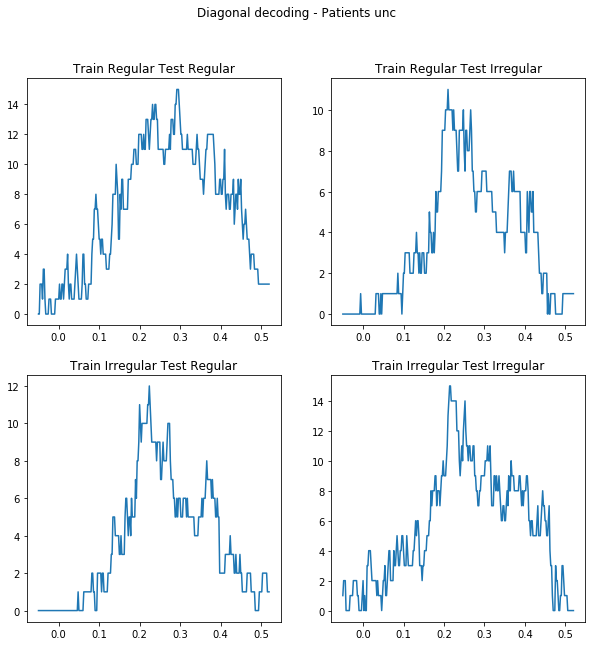

In [34]:
### four_plots(timevec,subtitles,diag_sig_unc_patients,'Patients unc')


We can examine the ROC AUC scores for the same subjects, to check whether this phenomenon has anything to do with classification performance (it should!). For that, we overlay the FDR-corrected timewise significance of the Mann-Whitney U-test with the ROC AUC performance of the problematic subjects

In [158]:
#diag_sig_fdr_controls,diag_sig_unc_controls,diag_ROC_controls = diagonal_group(controls_id,statspath,0.05,timevec=timevec,doplots=True)
#diag_sig_fdr_patients,diag_sig_unc_patients,diag_ROC_patients = diagonal_group(patients_id,statspath,0.05,timevec=timevec,doplots=True)

To illustrate this at the group level, let's now plot the average and std of ROC AUC for the whole groups. 

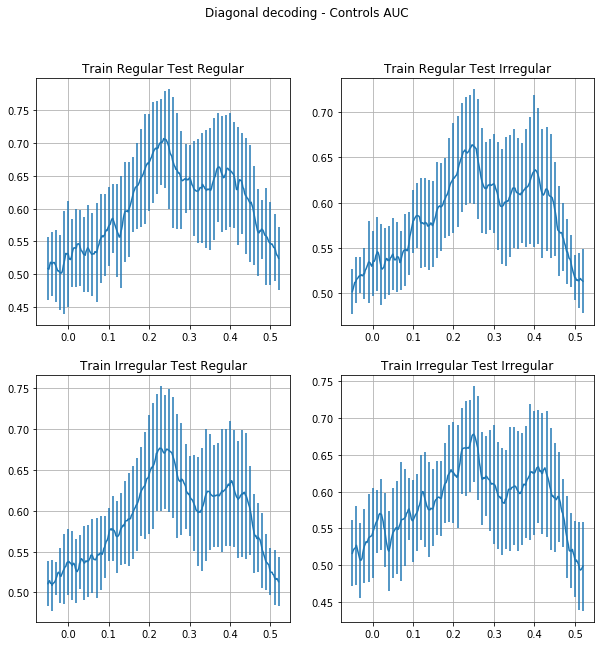

In [24]:
four_errorplots(timevec,subtitles,diag_roc=diag_ROC_controls,mytitle='Controls AUC')

For patients :

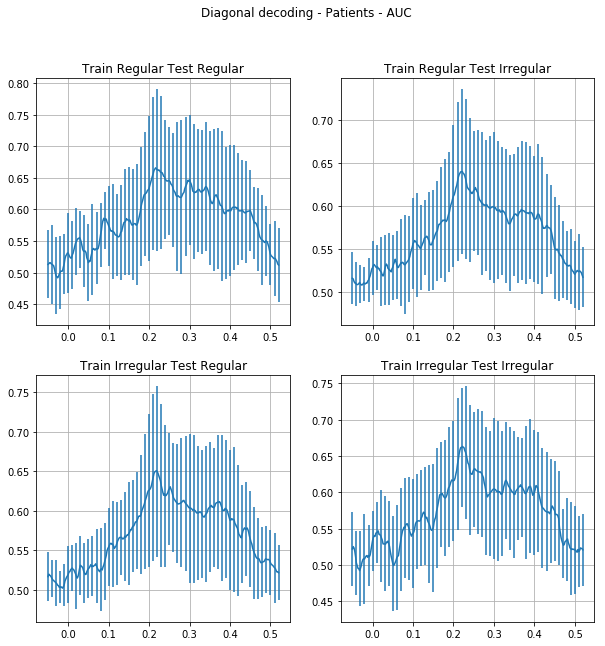

In [25]:
four_errorplots(timevec,subtitles,diag_roc=diag_ROC_patients,mytitle='Patients - AUC')

In [112]:
diag_sig_fdr_controls,diag_sig_unc_controls,diag_ROC_controls = diagonal_group(controls_id,statspath,0.05,doplots=False,threshold_zeros=30,keepall=False)
diag_sig_fdr_patients,diag_sig_unc_patients,diag_ROC_patients = diagonal_group(patients_id,statspath,0.05,doplots=False,threshold_zeros=30,keepall=False)

Showing subjects with less than 30 FDR significant points
Subj 180802_02k1_formal_conditionwise.npz has zero or few significant FDR : 0 
Showing subjects with less than 30 FDR significant points
Subj 180802_12c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_15c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_17c1_formal_conditionwise.npz has zero or few significant FDR : 3 
Subj 180802_11c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_14c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_04m1_formal_conditionwise.npz has zero or few significant FDR : 0 


In [113]:
diag_ROC_controls.shape

(19, 4, 286)

We can attempt to restrict to the 200  - 300 ms timewindow

In [114]:
tmin=110
tmax=170
timevec2 = timevec[tmin:tmax]
print(timevec2)

[0.17  0.172 0.174 0.176 0.178 0.18  0.182 0.184 0.186 0.188 0.19  0.192
 0.194 0.196 0.198 0.2   0.202 0.204 0.206 0.208 0.21  0.212 0.214 0.216
 0.218 0.22  0.222 0.224 0.226 0.228 0.23  0.232 0.234 0.236 0.238 0.24
 0.242 0.244 0.246 0.248 0.25  0.252 0.254 0.256 0.258 0.26  0.262 0.264
 0.266 0.268 0.27  0.272 0.274 0.276 0.278 0.28  0.282 0.284 0.286 0.288]


Controls

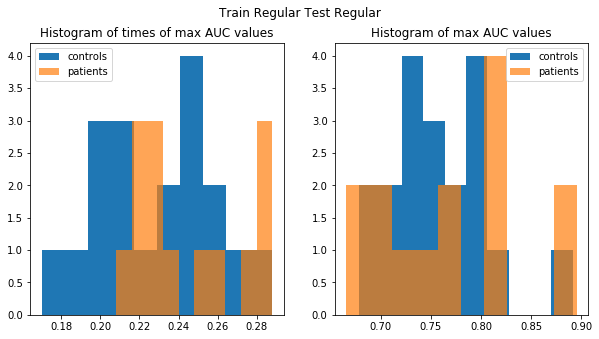

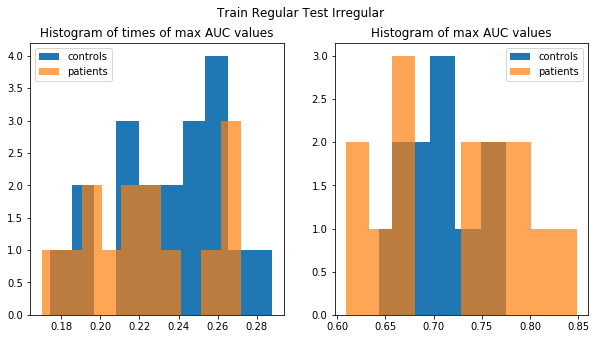

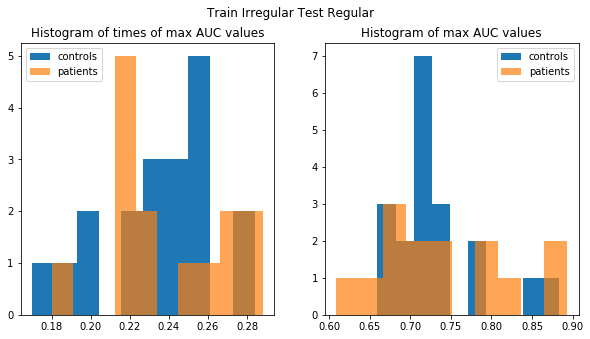

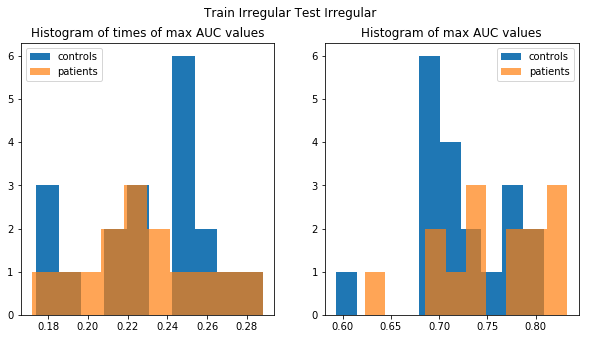

In [115]:
aucmaxtime_allcond_controls = []

aucmaxtime_allcond_patients = []

for i,sub in enumerate(subtitles):
    
    auc_max_controls = np.max(diag_ROC_controls[:,i,tmin:tmax],axis=1)
    times_auc_max_controls = timevec2[np.argmax(diag_ROC_controls[:,i,tmin:tmax],axis=1)]
    aucmaxtime_allcond_controls.append(np.vstack([auc_max_controls.T,times_auc_max_controls.T]))
    

    #print("AUC max :", auc_max_controls)
    #print("times :", times_auc_max_controls)

    #print("Patients")
    auc_max_patients = np.max(diag_ROC_patients[:,i,tmin:tmax],axis=1)
    times_auc_max_patients = timevec2[np.argmax(diag_ROC_patients[:,i,tmin:tmax],axis=1)]
    
    aucmaxtime_allcond_patients.append(np.vstack([auc_max_patients.T,times_auc_max_patients.T]))
    
    
    #print("AUC max :", auc_max_patients)
    #print("times :", times_auc_max_patients)

    f=plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.hist(times_auc_max_controls)
    plt.hist(times_auc_max_patients,alpha=0.7)
    plt.legend(['controls','patients'])
    plt.title('Histogram of times of max AUC values')

    plt.subplot(1,2,2)
    plt.hist(auc_max_controls)
    plt.hist(auc_max_patients,alpha=0.7)
    plt.legend(['controls','patients'])
    plt.title('Histogram of max AUC values')
            
    f.suptitle(sub)
    plt.show()

Now let's represent peak AUC and time of peak AUC for Reg / Reg versus Reg / Irreg , and Irreg / Reg

Text(0.5,1,'Time of Peak AUC')

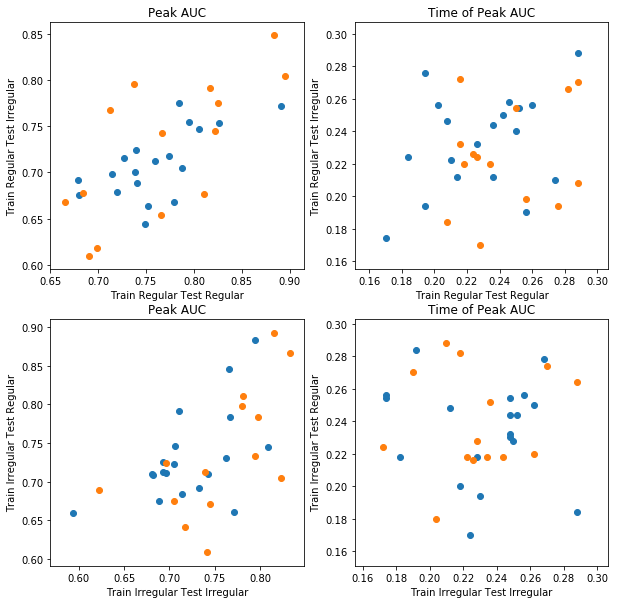

In [116]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.scatter(aucmaxtime_allcond_controls[0][0],aucmaxtime_allcond_controls[1][0])
plt.scatter(aucmaxtime_allcond_patients[0][0],aucmaxtime_allcond_patients[1][0])
plt.xlabel(subtitles[0])
plt.ylabel(subtitles[1])
plt.title('Peak AUC')

plt.subplot(2,2,2)
plt.scatter(aucmaxtime_allcond_controls[0][1],aucmaxtime_allcond_controls[1][1])
plt.scatter(aucmaxtime_allcond_patients[0][1],aucmaxtime_allcond_patients[1][1])
plt.xlabel(subtitles[0])
plt.ylabel(subtitles[1])
plt.title('Time of Peak AUC')

plt.subplot(2,2,3)
plt.scatter(aucmaxtime_allcond_controls[3][0],aucmaxtime_allcond_controls[2][0])
plt.scatter(aucmaxtime_allcond_patients[3][0],aucmaxtime_allcond_patients[2][0])
plt.xlabel(subtitles[3])
plt.ylabel(subtitles[2])
plt.title('Peak AUC')

plt.subplot(2,2,4)
plt.scatter(aucmaxtime_allcond_controls[3][1],aucmaxtime_allcond_controls[2][1])
plt.scatter(aucmaxtime_allcond_patients[3][1],aucmaxtime_allcond_patients[2][1])
plt.xlabel(subtitles[3])
plt.ylabel(subtitles[2])
plt.title('Time of Peak AUC')



In [125]:
from scipy.stats import pearsonr,spearmanr

print('Controls, AUC, Reg / Irreg', pearsonr(aucmaxtime_allcond_controls[0][0],aucmaxtime_allcond_controls[1][0]))

print('Controls, time of max AUC, Reg / Irreg', pearsonr(aucmaxtime_allcond_controls[0][1],aucmaxtime_allcond_controls[1][1]))

print('Controls, AUC, IrReg / reg', pearsonr(aucmaxtime_allcond_controls[3][0],aucmaxtime_allcond_controls[2][0]))

print('Controls, time of max AUC, IrReg / Reg', pearsonr(aucmaxtime_allcond_controls[3][1],aucmaxtime_allcond_controls[2][1]))


print('Patients, AUC, Reg / Irreg', pearsonr(aucmaxtime_allcond_patients[0][0],aucmaxtime_allcond_patients[1][0]))

print('Patients, time of max AUC, Reg / Irreg', pearsonr(aucmaxtime_allcond_patients[0][1],aucmaxtime_allcond_patients[1][1]))

print('Patients, AUC, IrReg / reg', pearsonr(aucmaxtime_allcond_patients[3][0],aucmaxtime_allcond_patients[2][0]))

print('Patients, time of max AUC, IrReg / Reg', pearsonr(aucmaxtime_allcond_patients[3][1],aucmaxtime_allcond_patients[2][1]))





Controls, AUC, Reg / Irreg (0.6546993553006604, 0.0023516218297695507)
Controls, time of max AUC, Reg / Irreg (0.36885335767762634, 0.12017685666592229)
Controls, AUC, IrReg / reg (0.5422405471580302, 0.016464696463034268)
Controls, time of max AUC, IrReg / Reg (-0.14040213133761956, 0.5664396426650287)
Patients, AUC, Reg / Irreg (0.703206885827774, 0.005020730719527381)
Patients, time of max AUC, Reg / Irreg (0.21707262438876734, 0.45600286287793357)
Patients, AUC, IrReg / reg (0.6170941475367944, 0.01872468859250512)
Patients, time of max AUC, IrReg / Reg (0.14753403392314837, 0.6147365061075953)


In [126]:

print('Controls, AUC, Reg / Irreg', spearmanr(aucmaxtime_allcond_controls[0][0],aucmaxtime_allcond_controls[1][0]))

print('Controls, time of max AUC, Reg / Irreg', spearmanr(aucmaxtime_allcond_controls[0][1],aucmaxtime_allcond_controls[1][1]))

print('Controls, AUC, IrReg / reg', spearmanr(aucmaxtime_allcond_controls[3][0],aucmaxtime_allcond_controls[2][0]))

print('Controls, time of max AUC, IrReg / Reg', spearmanr(aucmaxtime_allcond_controls[3][1],aucmaxtime_allcond_controls[2][1]))


print('Patients, AUC, Reg / Irreg', spearmanr(aucmaxtime_allcond_patients[0][0],aucmaxtime_allcond_patients[1][0]))

print('Patients, time of max AUC, Reg / Irreg', spearmanr(aucmaxtime_allcond_patients[0][1],aucmaxtime_allcond_patients[1][1]))

print('Patients, AUC, IrReg / reg', spearmanr(aucmaxtime_allcond_patients[3][0],aucmaxtime_allcond_patients[2][0]))

print('Patients, time of max AUC, IrReg / Reg', spearmanr(aucmaxtime_allcond_patients[3][1],aucmaxtime_allcond_patients[2][1]))



Controls, AUC, Reg / Irreg SpearmanrResult(correlation=0.5912280701754385, pvalue=0.007676472592226471)
Controls, time of max AUC, Reg / Irreg SpearmanrResult(correlation=0.2508787346221441, pvalue=0.30020099249946985)
Controls, AUC, IrReg / reg SpearmanrResult(correlation=0.48947368421052634, pvalue=0.03341526206953935)
Controls, time of max AUC, IrReg / Reg SpearmanrResult(correlation=-0.023841173459281904, pvalue=0.9228222264672503)
Patients, AUC, Reg / Irreg SpearmanrResult(correlation=0.7054945054945055, pvalue=0.004819557979048519)
Patients, time of max AUC, Reg / Irreg SpearmanrResult(correlation=0.050716679116302656, pvalue=0.8632951164115567)
Patients, AUC, IrReg / reg SpearmanrResult(correlation=0.6131868131868132, pvalue=0.019706331926038816)
Patients, time of max AUC, IrReg / Reg SpearmanrResult(correlation=0.024282797371613384, pvalue=0.9343302638264976)
